In [1]:
import xarray as xr
import numpy as np

from scipy import stats                                                         

import matplotlib.pyplot as plt
import seaborn as sns

import sstats.tseries as ts
import sstats.sigp as sigp
import sstats.hfreq as hf

# dev
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
# https://www.wrighters.io/using-autoreload-to-speed-up-ipython-and-jupyter-work/
%reload_ext autoreload
%autoreload 1
#%aimport sstats
%aimport sstats

In [2]:
from sympy import Symbol, pi, atan, factor, lambdify

In [22]:
u_high = hf.high_frequency_signal(stationary=True)
u = hf.add(u_high, u_high, labels=["high0", "high1"])
#u = hf.high_frequency_signal(stationary=True)

In [23]:
omegac = Symbol('omega_c', positive=True)
domega = Symbol('domega', positive=True)
sigma0_sp,sigma1_sp = u.p['sigma_high0'],u.p['sigma_high1']
#sigma_sp = Symbol('domega', positive=True)
#T_sp, U_sp = u.p['T'], u.p['U']
omega_sp, tau_sp  = u.omega, u.tau

## Autocovariance and power spectra

In [24]:
print('Power spectra formula (for an exponential autocorrelation), one component: ')
u.spectrum

Power spectra formula (for an exponential autocorrelation), one component: 


T_high0*U_high0**2*(T_high0**2*(omega**2 + sigma_high0**2) + 1)/(T_high0**4*(-omega**2 + sigma_high0**2)**2 + 2*T_high0**2*(omega**2 + sigma_high0**2) + 1) + T_high1*U_high1**2*(T_high1**2*(omega**2 + sigma_high1**2) + 1)/(T_high1**4*(-omega**2 + sigma_high1**2)**2 + 2*T_high1**2*(omega**2 + sigma_high1**2) + 1) + pi*U_s_high0**2*(DiracDelta(-omega + sigma_high0) + DiracDelta(omega + sigma_high0))/2 + pi*U_s_high1**2*(DiracDelta(-omega + sigma_high1) + DiracDelta(omega + sigma_high1))/2

In [25]:
tau = np.arange(0,300,1/24)
rad = 2*np.pi
om = rad*np.linspace(1,3,500)

In [92]:
u.autocorrelation

U_high0**2*exp(-tau/T_high0)*cos(sigma_high0*tau)/2 + U_high1**2*exp(-tau/T_high1)*cos(sigma_high1*tau)/2

In [32]:
psd = lambda omega,T,U,Us,sigma0,sigma1 : u.spectrum_lbd(omega,U,U,Us,Us,sigma0,sigma1,T,T)
exp_func = lambda tau,T,U,Us,sigma0,sigma1 : u.autocorrelation_lbd(tau,U,U,Us,Us,sigma0,sigma1,T,T)

In [27]:
Ttilde = [5,20,40]
U,Us = 1,1
#omega_c = [0.2,0.5,0.9]

In [28]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}



tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#center frequency
Tw = 30 #filter length
dband = 0.2 # half-bandwidth

print('omega M2:%s'%omega_M2)
print('omega S2:%s'%omega_S2)
print('omega N2:%s'%omega_N2)
print('omega K2:%s'%omega_K2)

omega M2:1.9322736142672448
omega S2:2.0
omega N2:1.8959819677542018
omega K2:2.0054758185413344


In [29]:
def Crr_inc(tau,U,T):
    return U**2*np.exp(-tau/T)*np.cos(rad*Omega*tau)
def Crr_mix(tau,U,T):
    return (U**2+0.5*U**2*np.exp(-tau/T))*np.cos(rad*Omega*tau)

### Figures 

In [20]:
import matplotlib as mpl
mpl.rcParams['font.size']=13

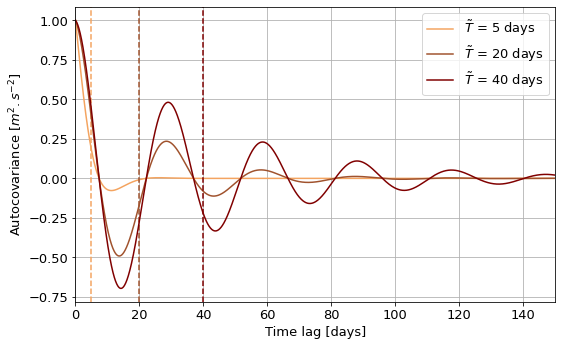

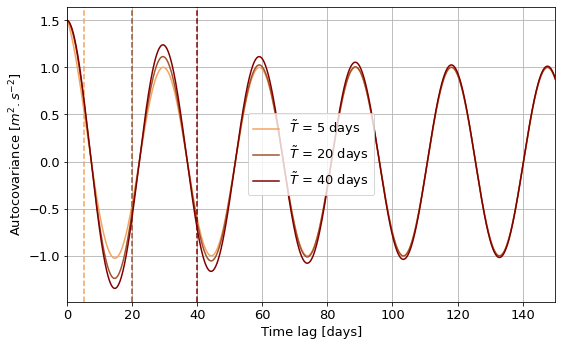

In [21]:
Omega = abs(omega_S2-omega)
colors = ['sandybrown','sienna','maroon']
fig,ax = plt.subplots(figsize=(8,5))
for i,T in enumerate(Ttilde):
    c = colors[i]
    ax.plot(tau,Crr_inc(tau,U,T),c=c,label=r'$\tilde{T}$ = %s days'%T)
    ax.axvline(T,linestyle='--',c=c)
ax.grid();ax.legend();ax.set_xlim(0,150)
ax.set_ylabel(r'Autocovariance [$m^2.s^{-2}$]');
ax.set_xlabel('Time lag [days]');
fig.tight_layout();
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/hf_autocov_th_inc.pdf')

fig,ax = plt.subplots(figsize=(8,5))
for i,T in enumerate(Ttilde):
    c = colors[i]
    ax.plot(tau,Crr_mix(tau,U,T),c=c,label=r'$\tilde{T}$ = %s days'%T)
    ax.axvline(T,linestyle='--',c=c)
ax.grid();ax.legend();ax.set_xlim(0,150)
ax.set_ylabel(r'Autocovariance [$m^2.s^{-2}$]');
ax.set_xlabel('Time lag [days]');
fig.tight_layout();
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/hf_autocov_th_mix.pdf')

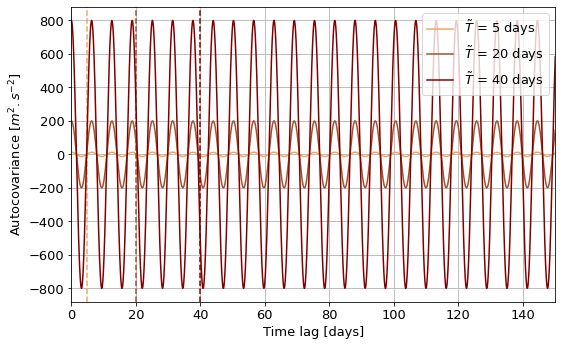

In [41]:
sigma_M2 = abs(omega_M2-omega)
sigma_S2 = abs(omega_S2-omega)
colors = ['sandybrown','sienna','maroon']
fig,ax = plt.subplots(figsize=(8,5))
for i,T in enumerate(Ttilde):
    c = colors[i]
    ax.plot(tau,exp_func(tau,T,U,Us,rad*sigma_M2,rad*sigma_S2),c=c,label=r'$\tilde{T}$ = %s days'%T)
    ax.axvline(T,linestyle='--',c=c)
ax.grid();ax.legend();ax.set_xlim(0,150)
ax.set_ylabel(r'Autocovariance [$m^2.s^{-2}$]');
ax.set_xlabel('Time lag [days]');
fig.tight_layout();
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/hf_autocov_th.pdf')

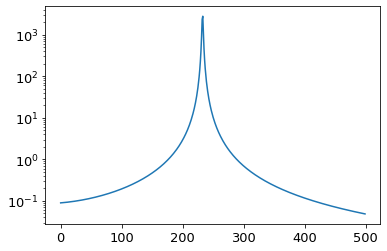

In [39]:
plt.plot(psd(om,T,U,Us,rad*omega_M2,rad*omega_S2))
plt.yscale('log');#plt.xscale('log')

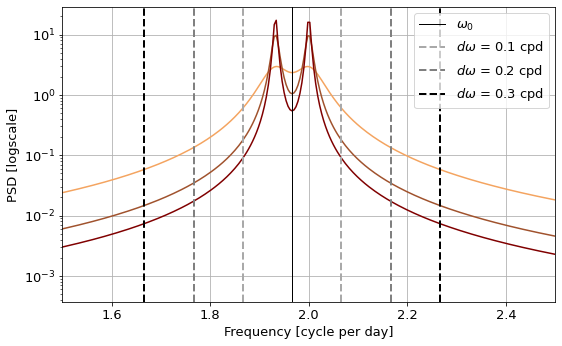

In [153]:
col_omega = ['darkgrey','grey','k']
fig,ax = plt.subplots(figsize=(8,5))
for i,T in enumerate(Ttilde):
    c = colors[i]
    ax.plot(om/rad,psd(om,T,U,rad*omega_M2,rad*omega_S2),c=c) #,label=r'$\tilde{T}$ = %s days'%T
#for i,T in enumerate(Tbar):
#    c = col_omega[i]
#    ax.axvline(omega_c[i],linestyle='--',c=c,label=r'$\omega_c$ = %s cpd'%omega_c[i])
ax.grid();ax.set_yscale('log');#ax.set_xscale('log')
ax.set_ylabel(r'PSD [logscale]');ax.set_xlim(1.5,2.5)
ax.axvline(omega,c='k',linestyle='-',label=r'$\omega_0$',linewidth=1);
for j,dom in enumerate([0.1,0.2,0.3]):
    ax.axvline(omega-dom,c=col_omega[j],linestyle='--',linewidth=2);
    ax.axvline(omega+dom,c=col_omega[j],linestyle='--',label=r'$d\omega$ = %s cpd'%dom,linewidth=2);
ax.legend()
ax.set_xlabel('Frequency [cycle per day]');
fig.tight_layout();
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/hf_spectra_th.pdf')

## Energy estimates

In [160]:
#domega = 0.2

In [171]:
I = u.spectrum.integrate((omega_sp, -domega, domega)) *2  /2/pi
I = I.simplify()
#E = lambdify([U_sp, T_sp, omegac], I)

print('Energy at high frequency after filtering : ')
I


KeyboardInterrupt



In [172]:
u.spectrum.integrate((omega_sp,0,domega))


KeyboardInterrupt



### Contamination

In [42]:
domega = np.linspace(0,1,100)
tbar = np.arange(0,300)


In [43]:
u_low = hf.low_frequency_signal()

In [44]:
psd_low = lambda omega,T,U : u_low.spectrum_lbd(omega,T,U)


In [68]:
Tbar, DOmega = np.meshgrid(tbar,domega)
Tdom = Tbar*DOmega
Tom = tbar*omega


In [46]:
TOM = np.meshgrid(Tom,domega)[0]

In [81]:
Econt = lambda Tdomega,Tomega0 : -2*np.arctan(2*Tdomega/(Tdomega**2-Tomega0**2-1))/np.pi

contamination = lambda domega,T,omega0 : abs(2*T*domega/(T**2*(domega**2-omega0**2)-1))
Econt = lambda domega,T,omega0,U : -2*U*np.arctan(-contamination(domega,T,omega0))/np.pi

In [59]:
Tb,om_c = np.meshgrid([2,20,200],[0.1,0.2,0.3])

In [49]:
dt = 1/24
DT = tbar.max()
N = DT/dt
Ne = lambda T,N,dt : N*(1-np.exp(-2*dt/T))

### Figures

In [60]:
Colors = np.meshgrid(colors,[2,20,200])[0]

/var/folders/8p/ctkm_wt55j54lh09mdw3yv0r00g___/T/ipykernel_1841/2010385653.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.contourf(tbar,domega,np.log10(contamination(DOmega,Tbar,omega)),cmap='bone',levels=100)
/var/folders/8p/ctkm_wt55j54lh09mdw3yv0r00g___/T/ipykernel_1841/2010385653.py:5: RuntimeWarning: divide by zero encountered in log10
  cs = ax.contourf(tbar,domega,np.log10(Econt(DOmega,Tbar,omega,1)),cmap='bone',levels=100)


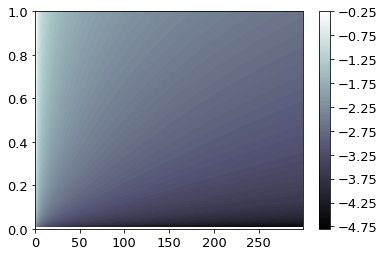

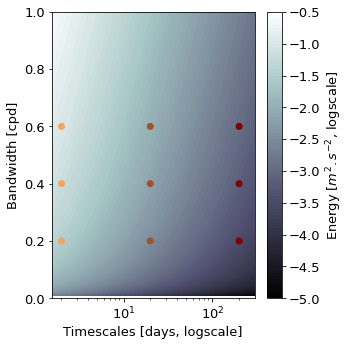

In [94]:
plt.contourf(tbar,domega,np.log10(contamination(DOmega,Tbar,omega)),cmap='bone',levels=100)
plt.colorbar();#plt.xscale('log')

fig,ax = plt.subplots(figsize=(5,5))
cs = ax.contourf(tbar,domega,np.log10(Econt(DOmega,Tbar,omega,1)),cmap='bone',levels=100)
clb = plt.colorbar(cs);plt.xscale('log')
clb.set_label(r'Energy [$m^2.s^{-2}$, logscale]')
ax.set_ylabel('Bandwidth [cpd]');ax.set_xlabel('Timescales [days, logscale]');
ax.scatter(Tb.flatten(),2*om_c.flatten(),c=Colors.flatten(),zorder=1,alpha=1);
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/Econtamination_th.png')

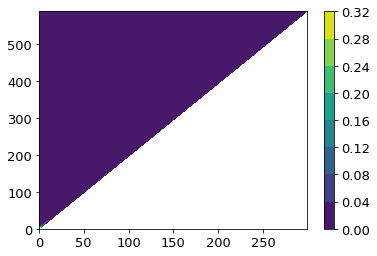

In [57]:
plt.contourf((Tbar*DOmega).T,Tbar.T*omega,Econt(Tbar*DOmega,Tbar*omega).T)
plt.colorbar();

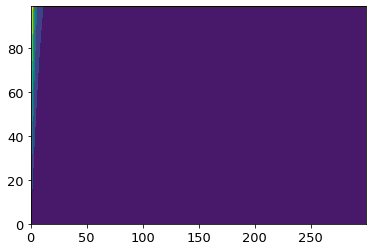

In [246]:
plt.contourf(Econt(Tdom,TOM.T).T)

In [251]:
Tdom.T[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

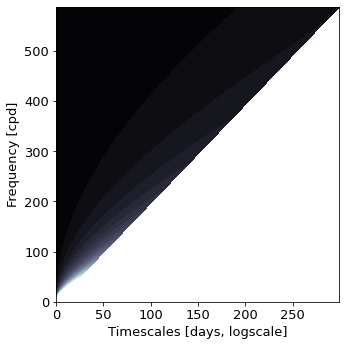

In [255]:
from matplotlib import ticker
fig,ax = plt.subplots(figsize=(5,5))
ax.contourf(Tdom.T,(Tbar*omega).T,1*Econt(Tdom,TOM.T).T/1,levels=500,vmax=0.02,cmap='bone')
#plt.colorbar(cs);
#ax.set_xscale('log')
#CS = ax.contour(Tbar.T,Omega_c.T,loss(Omega_c,Tbar).T,levels=[0.1,0.5,0.9],colors='r')
#ax.clabel(CS, CS.levels, fmt='%2.1f', inline=1, fontsize=10)
#ax.scatter(Tb.flatten(),om_c.flatten(),c=Colors.flatten(),zorder=1,alpha=1);
#ax.set_ylim(0,0.6);
ax.set_ylabel('Frequency [cpd]');ax.set_xlabel('Timescales [days, logscale]')
fig.tight_layout();
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/energyloss_th_methodo.pdf')

/var/folders/8p/ctkm_wt55j54lh09mdw3yv0r00g___/T/ipykernel_2015/3644365525.py:4: RuntimeWarning: divide by zero encountered in true_divide
  Ne = lambda T,N,dt : N*(1-np.exp(-2*dt/T))


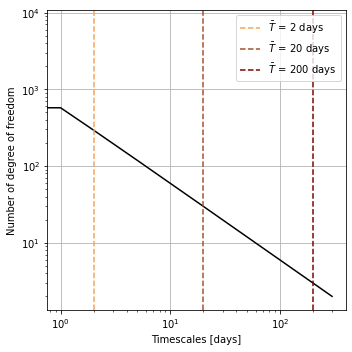

In [140]:
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(tbar,Ne(tbar,N,dt),c='k');ax.set_yscale('log');ax.set_xscale('log')
ax.set_ylabel('Number of degree of freedom');ax.set_xlabel('Timescales [days]')
for i,T in enumerate([2,20,200]):
    ax.axvline(T,c=colors[i],linestyle='--',label=r'$\bar T$ = %s days'%T)
ax.legend();ax.grid()
fig.tight_layout();
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/Ne_th_methodo.pdf')